In [132]:
import requests
import re
import time
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

In [67]:
""" Create a dict with song titles as keys and the song URL as values """

url = requests.get("https://www.azlyrics.com/b/bowie.html", timeout=5)
t = url.text

songlist = re.search("songlist = \[\r\n(.*?)\]", t, re.DOTALL).group(1)

songlist = re.findall("\{(.*?)\}", songlist)

d = {}

for s in songlist:
    
    # dict[song_title] = song_URL
    
    d[re.search("s\:\"(.*?)\"", s).group(1)] = "https://www.azlyrics.com/" + re.search("h\:\"(.*?)\"", s).group(1)[2:]

# two point fixes for songs under another artist's URL:

d['Cosmic Dancer (Live)'] = 'https://www.azlyrics.com/lyrics/morrissey/cosmicdancerlive.html'
d['Under Pressure'] = 'https://www.azlyrics.com/lyrics/queen/underpressure.html'

In [116]:
""" Create a dict (from Wiki page saved as CSV) with song titles as keys and the song debut year (as int) as values """

df = pd.read_csv ('wiki_bowie_songs.csv', names=["title","year"])

years = {}

for index, row in df.iterrows():
    years[row["title"].lower()] = row["year"]
        
# Since there are some inconsistencies between Wikipedia and AZlyrics.com,
# create a new dict based on original order/songlist

years_new = {}

for s in d:
    lowercase_song = s.lower()
    if lowercase_song in list(years.keys()):
        years_new[s] = years[lowercase_song]
        
# trim original according to keylist of new dict

for s in list(d.keys()):
    if s not in years_new:
        del d[s]
    
print(len(d))

323


In [3]:
def get_lyrics(lyrics_url):

    url = requests.get(lyrics_url, timeout=5)
    t = url.text

    lyrics = re.search("Sorry about that\. \-\-\>(.*?)\<\/div\>", t, re.DOTALL).group(1)

    lyrics = re.split("<br>|\r|\n", lyrics)
    lyrics = [x for x in lyrics if x != ""]
    lyrics = " ".join(lyrics)

    return lyrics

In [ ]:
""" Get all DB song lyrics from the site and save them to a .txt file """

f = open("db_lyrics.txt","a", encoding="utf8")

for s in list(d.keys())[321:]:
    try:
        lyrics = get_lyrics(d[s])
    except:
        print("Unable to get lyrics for" + s + ". Closing file now.")
        f.close()
        break
        
    print("Writing lyrics for the song", s, ".")
        
    f.write(s + " ### " + lyrics + " ### ")

    time.sleep(30) # so we don't get our IP address blocked again

f.close()

In [125]:
lyrics_raw = open("db_lyrics.txt", encoding="utf8") # open .txt file containing all lyrics
lyrics_raw = lyrics_raw.read()
lyrics_raw = lyrics_raw.split(" ### ") # split with " ### " delimiter

# lyrics_raw = lyrics_raw[1::2] # no song names, only lyrics
len(lyrics_raw)

# create a dict of lyrics

lyr = {}

for x in range(0, len(lyrics_raw)-2, 2):
    lyr[lyrics_raw[x]] = lyrics_raw[x+1]
    
# trim lyrics dict like we trimmed d above

for s in list(lyr.keys()):
    if s not in years_new:
        del lyr[s]
        
len(lyr)

323

In [166]:
song_info = {"title": list(d.keys()), "year": list(years_new.values()), "url": list(d.values()), "lyrics": list(lyr.values())}
df = pd.DataFrame(data = song_info)

In [167]:
def lemma_count(lyrics):
    
    """ Given raw lyrics of a song, return count of unique lemmata """

    tokens = nlp(lyrics)

    lemmata = []

    for t in tokens:
        if t.is_alpha and not t.is_stop:
            wd = str(t)

            if wd not in lemmata:
                lemmata.append(wd)

    return len(lemmata)

In [169]:
df['lemma_count'] = df.apply(lambda row: lemma_count(row.lyrics), axis=1)

AxesSubplot(0.125,0.125;0.775x0.755)


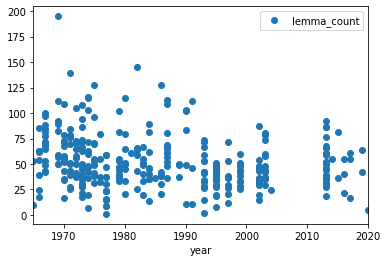

In [173]:
print(df.plot(x='year', y='lemma_count', style='o'))